<a href="https://colab.research.google.com/github/magistery-tps/dm-cyt-tp/blob/main/notebooks/analisys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####  Referencias

* [Pandas pipelines](https://calmcode.io/pandas-pipe/end.html)
* [Python logger](https://www.youtube.com/watch?v=g8nQ90Hk328&list=PLi01XoE8jYohWFPpC17Z-wWhPOSuh8Er-&index=17)
* [Dataset](https://smallworldofwords.org/en/project/research)
* [Glove word embedding](https://nlp.stanford.edu/projects/glove/)
* [Elmo word embedding](https://allennlp.org/elmo)
* [Basics of Using Pre-trained GloVe Vectors in Python](https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db)

####  Ejemplos

* [Ejemplo word2vect](https://colab.research.google.com/drive/1YcplHjDL1M6G9K62W4GyUbic0OxOt8GZ?usp=sharing)
* [Ejemplo carga de dataset](https://colab.research.google.com/drive/1Qlq56GM6xERVpy6FAJhS5XCqaAKGlGtD?usp=sharing)
* [Análisis de Redes 1](https://colab.research.google.com/drive/1ef-fnqmPsAxqlIc_ZrBXa0Fg6IYYf_g_?usp=sharing)
* [Análisis de Redes 2](https://colab.research.google.com/drive/1IaIreaEvIXiOq0gmjYJw7Q1y9lhY20ZM?usp=sharing#scrollTo=4v-e0C44llje)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import clear_output
import sys
import os.path
from os import path

def is_runing_into_colab_env():
    try:
        import google.colab
        return True
    except:
        return False

### 1. Instalacion de paquetes

In [3]:
if is_runing_into_colab_env(): 
    !pip install networkx
    !pip install gensim

###  2. Importa libreria del proyecto

In [4]:
if is_runing_into_colab_env():
    if path.exists('/content/dm-cyt-tp2'):
        print('Pull...\n')
        !cd dm-cyt-tp2; git pull origin main
    else:
        print('Clone...\n')
        !git clone https://github.com/magistery-tps/dm-cyt-tp2.git

Clone...

Cloning into 'dm-cyt-tp2'...
remote: Enumerating objects: 458, done.
remote: Counting objects: 100% (458/458), done.
remote: Compressing objects: 100% (313/313), done.
remote: Total 458 (delta 228), reused 310 (delta 109), pack-reused 0
Receiving objects: 100% (458/458), 70.51 MiB | 14.14 MiB/s, done.
Resolving deltas: 100% (228/228), done.


In [5]:
sys.path.append('/content/dm-cyt-tp2/src' if is_runing_into_colab_env() else '../src')
dataset_path = '/content/dm-cyt-tp2/datasets/{}' if is_runing_into_colab_env() else '../datasets/{}'

###  3. Importa paquetes externos

In [6]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import numpy as np
import pandas as pd
import networkx as nx
import logging

from logger import setup_logger

from step   import rename_columns, \
                   plot_frequency, \
                   select

from graph  import graph_summary, \
                   graph_edges, \
                   plot_weight_dist, \
                   plot_clustering_coeficient_dist, \
                   plot_degree_dist, \
                   plot_cumulative_degree_dists, \
                   plot_centrality_mesures_heatmap, \
                   graph_subsampling, \
                   plot_modularity_coeficient, \
                   graph_modularity, \
                   subgraph_without_isolated_nodes, \
                   isolated_nodes, \
                   plot_adjacency_matrix, \
                   plot_adjacency_matrix2, \
                   GraphFactory, \
                   to_undirected_graph, \
                   graph_components_nodes_size, \
                   largest_component_diameter, \
                   largest_component_average_shortest_path_length, \
                   top_degree_centrality, \
                   plot_graph, \
                   graph_largest_component, \
                   top_degree_centrality_subgraph, \
                   plot_graph_eigenvector_centrality, \
                   plot_degree_centrality, \
                   plot_betweenness_centrality, \
                   plot_closeness_centrality

from embedding import GoogleW2VSimilarity

from dataset import summary

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
setup_logger(format = '%(levelname)s: %(message)s')

### 4. Cargar dataset

(367188, 5)
INFO: NumExpr defaulting to 2 threads.


,source,response,sww_weight,w2v_google_weight,w2v_glove_weight
0,although,nevertheless,0.033333,0.604110,NaN
1,although,though,0.033333,0.784028,NaN
2,although,question,0.033333,0.091440,NaN
3,although,however,0.033333,0.614937,NaN
4,although,even,0.033333,0.522209,NaN


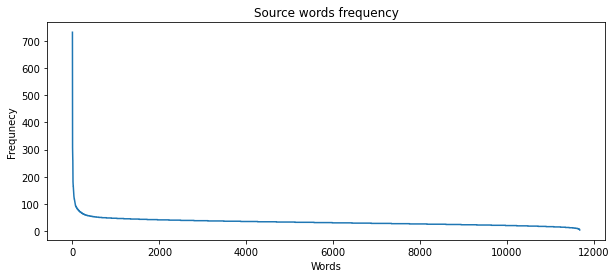

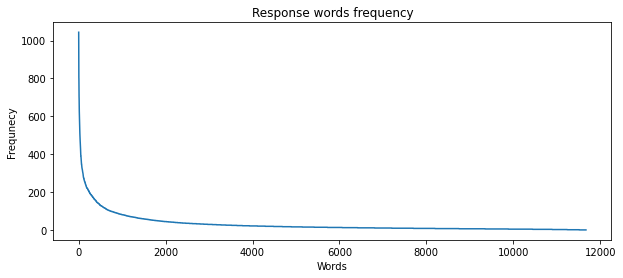

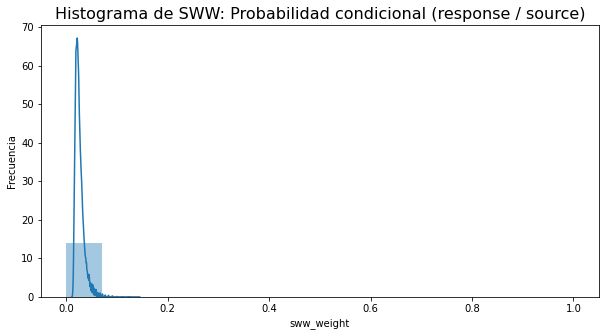

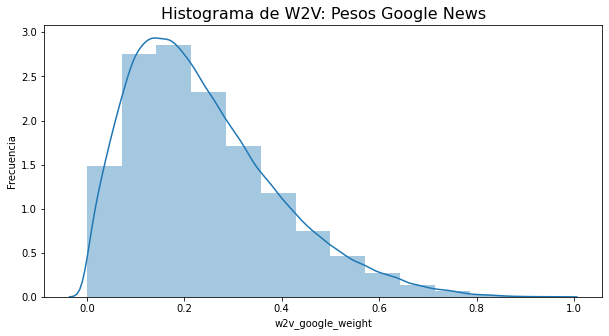

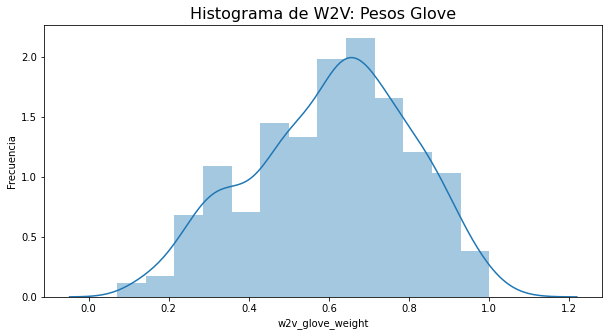

In [8]:
dataset = pd.read_csv(dataset_path.format('processed_dataset.csv'))
summary(dataset)

### 5. Tareas

#### 5.1. Construcción de los grafos

A continacion tomamos por un lado **dataset** (el cual tiene las columnas pregunta y respuesta) y por el otro el diccionario de **word_embeddings** y finalmente convertimos ambos datasets en grafos.

Creamos un dataset pesado por la distancia coseno entre las palabras fitlradas desde **Small World of Words**:

In [9]:
graph_subsampling_percent = 0.1

# W2V:
w2v_weight_type  = 'google' # 'glove'
w2v_min_distance = 0

# SWW:
sww_min_distance = 0

In [10]:
w2v_weight_column = 'w2v_{}_weight'.format(w2v_weight_type)
w2v_weight_column

'w2v_google_weight'

**Grafo W2V**

Creamos el grafo Gw2v con los pesos selecionado de la columna **w2v_weight_column** (Ver setting mas arriba):

In [11]:
w2v_dataset = dataset[
        dataset[w2v_weight_column].notnull() &
        dataset[w2v_weight_column] > w2v_min_distance
    ] \
    .pipe(rename_columns, { w2v_weight_column: 'weight' }) \
    .pipe(select, ['source', 'response', 'weight'])

INFO: (350243, 5) --> rename_columns({}) --> (350243, 5)
INFO: (350243, 5) --> select({}) --> (350243, 3)


Creamos un grafo pesado:

Información:
Graph with 1118 nodes and 2831 edges
- ¿Es un grafo conexo?  No
- ¿Es un grafo pesado?  Si
- ¿Es un grafo dirigido?  No
- ¿Es un grafo con ciclos?  Si
- ¿Es un grafo con multiples aristas?  No


<Figure size 720x360 with 0 Axes>

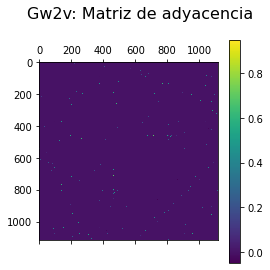

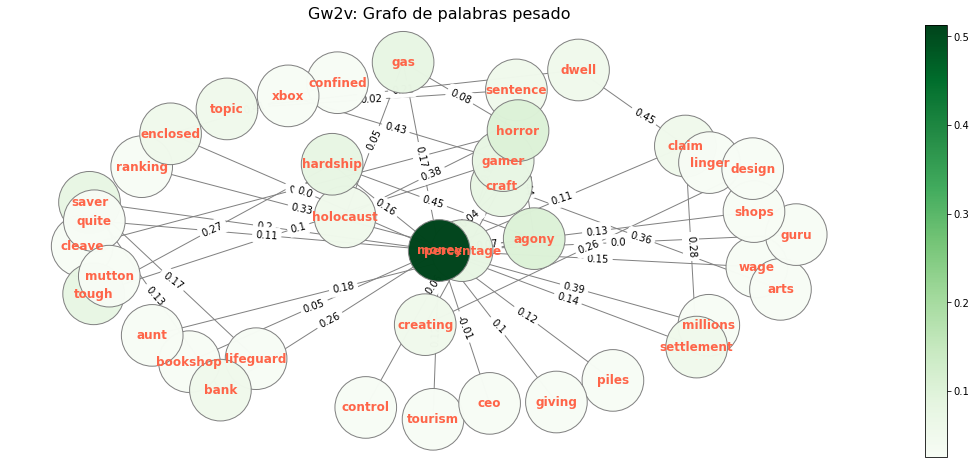

In [12]:
w2v_graph = GraphFactory.create_undirected_weihted_graph(w2v_dataset)

w2v_graph = graph_subsampling(w2v_graph,  percent = graph_subsampling_percent, seed=42)

w2v_graph = subgraph_without_isolated_nodes(w2v_graph)

graph_summary(w2v_dataset, w2v_graph, k_percent=0.15, nodes_distance=5, title='Gw2v')

**Nota**: Cuando mas oscuro es el color del nodo, mayor centralidad de grado.

**Grafo SWW**

Creamos el grafo con los pesos corresspondiende a la probabilidad condicional **P(response / source)**:

In [13]:
sww_dataset = dataset[
        dataset.sww_weight.notnull() &
        dataset.sww_weight > sww_min_distance
    ] \
    .pipe(rename_columns, { 'sww_weight': 'weight' }) \
    .pipe(select, ['source', 'response', 'weight'])

INFO: (367188, 5) --> rename_columns({}) --> (367188, 5)
INFO: (367188, 5) --> select({}) --> (367188, 3)


Información:
DiGraph with 1118 nodes and 3122 edges
- ¿Es un grafo pesado?  Si
- ¿Es un grafo dirigido?  Si
- ¿Es un grafo con ciclos?  Si
- ¿Es un grafo con multiples aristas?  No


<Figure size 720x360 with 0 Axes>

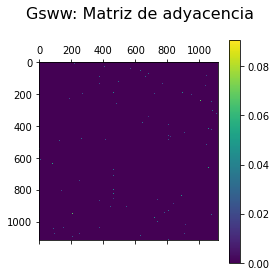

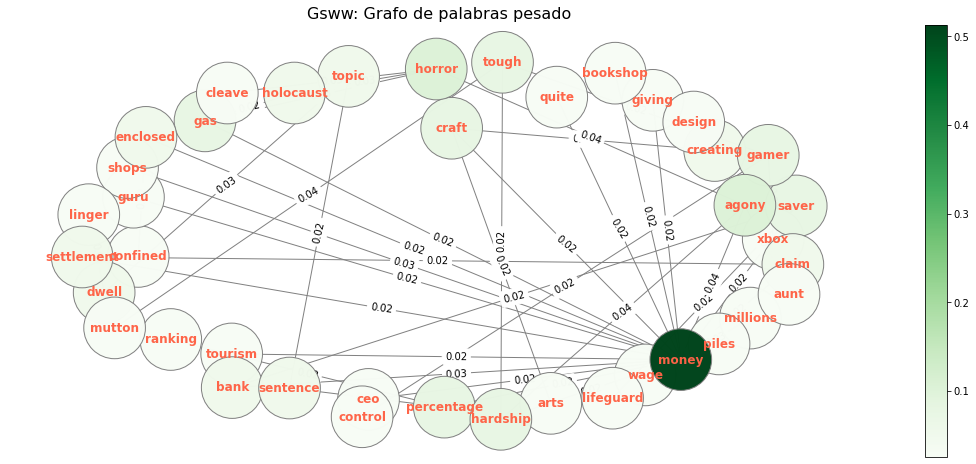

In [14]:
sww_graph = GraphFactory.create_directed_weihted_graph(sww_dataset)

## Importante: Nos quedamos solo con los mismos nodos que Gw2v.
sww_graph = sww_graph.subgraph(list(w2v_graph.nodes))

sww_graph = subgraph_without_isolated_nodes(sww_graph)

graph_summary(sww_dataset, sww_graph, k_percent=0.15, nodes_distance=5, title='Gsww')

**Nota**: Cuando mas oscuro es el color del nodo, mayor centralidad de grado.

Finalmente validamos qeu ambos grafos tengan los mismo nodos:

In [15]:
set(sww_graph.nodes) - set(w2v_graph.nodes)

set()

In [16]:
nx.info(sww_graph)

'DiGraph with 1118 nodes and 3122 edges'

In [17]:
nx.info(w2v_graph)

'Graph with 1118 nodes and 2831 edges'

#### 5.2. Carácterización de los grafos

Comparar los dos grafos en terminos de medidas de 

* Cliques/Clustering
* Medidas de centralidad
* Distribución de pesos
* Distribución de grado
* Asortatividad
* Camino mínimo
* Diámetro
* Etc...

¿Qué pueden decir de cada uno de los grafos? ¿Y qué pueden decir de la comparación entre ellos?

**Opcional 1**: ¿Cómo cambian los resultados si se considere Gsww como no-dirigido o no-pesado?

In [ ]:
undirected_sww_graph = to_undirected_graph(sww_dataset, sww_graph)
sww_largest_subgraph = graph_largest_component(undirected_sww_graph)
w2v_largest_subgraph = graph_largest_component(w2v_graph)

**Clustering**

Coeficiente de clustering

* Cuando hablamos de coeficiente de clustering hablamos de que le pasa a los primeros vecinos de un nodo. No solamente vemos el nodo, si no también sus alrededores.
* Esta medida observa si los vecinos del nodo están conectados entre sí y que tan conectaddos estan.
* Estudia la densidad de la red alrededor de cada uno de los nodos.


Districión del coeficiende de clustering para ambos grafos:

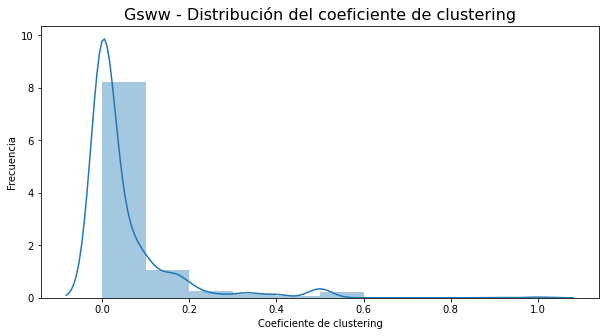

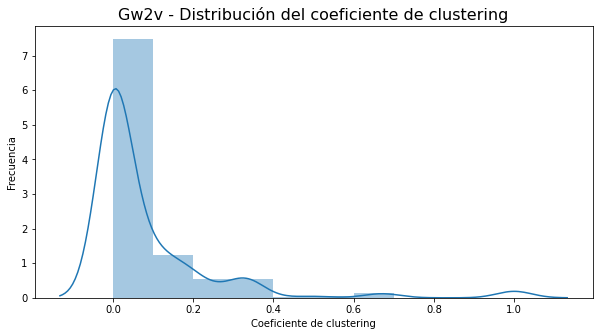

In [ ]:
plot_clustering_coeficient_dist(sww_graph, title='Gsww')
plot_clustering_coeficient_dist(w2v_graph, title='Gw2v')

**Observaciones**

Se aprecia que en ambos grafos existe el mismo patrón. Es decir, Tenemos muchos nodos con bajo coeficiente de clusteging y pocos con valores a partir de 0.2. Esto no dice que tenemos muy pocos nodos con vecinos muy conecados enter si y mucho nodos con vesinos poco conectados.



Coeficiente de clusteging global:

In [ ]:
nx.average_clustering(sww_graph)

0.05328773484080941

In [ ]:
nx.average_clustering(w2v_graph)

0.0870916329597051

**Observaciones**

Si medimos el coeficiente de clustering global, vemos que Gw2v tiene vecinos mas conectados entre si que Gsww, superandolo por un 40%.

**Medidas de centralidad**

* Son propeidades de un nodo que definen la importancia del mismo en la red.
* En general siempre se indica que el nodo más importante eselq eu tiene mayor grado, aquel que permite más atajos en la red. Sin embargo no es la única forma de ser importante en la red, existen distintas medidas se centralidad.


Centralidado de Grado

Cuanto mas grado tiene un nodo, mas importancia adquiere en la red.  

In [ ]:
sww_subgraph = subgraph_without_isolated_nodes(
    top_degree_centrality_subgraph(sww_largest_subgraph, top = 150)
)

w2v_subgraph = subgraph_without_isolated_nodes(
    top_degree_centrality_subgraph(w2v_largest_subgraph, top = 150)
)

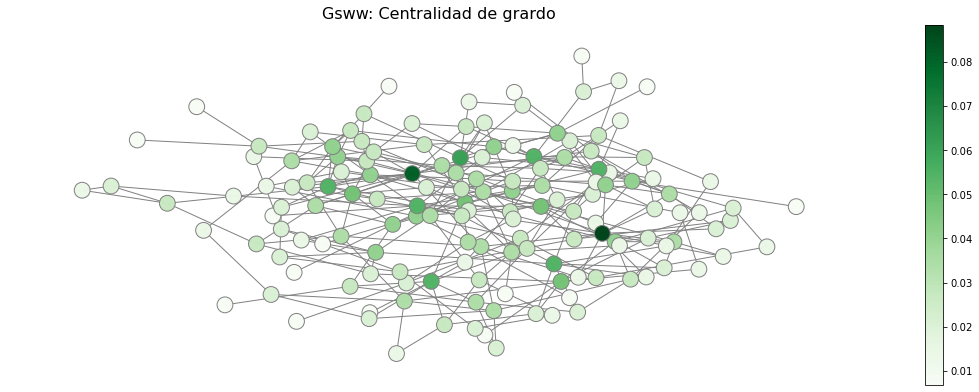

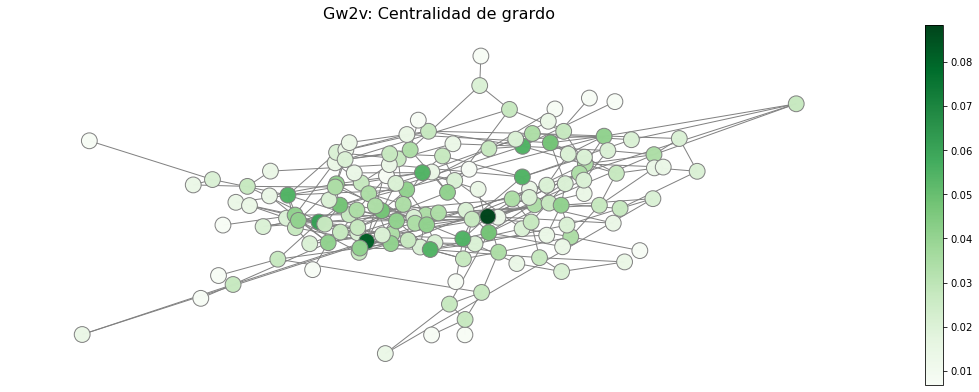

In [ ]:
plot_degree_centrality(sww_subgraph, 'Gsww', nodes_distance = 1)
plot_degree_centrality(w2v_subgraph, 'Gw2v', nodes_distance = 1)

Centralidado de Intermediación:

Mide cuántos caminos más cortos pasan por un nodo respecto a todos los caminos más cortos que existen en la red. Mientras más caminos cortos pasen por un nodo, más relevanncia tiene en la red.

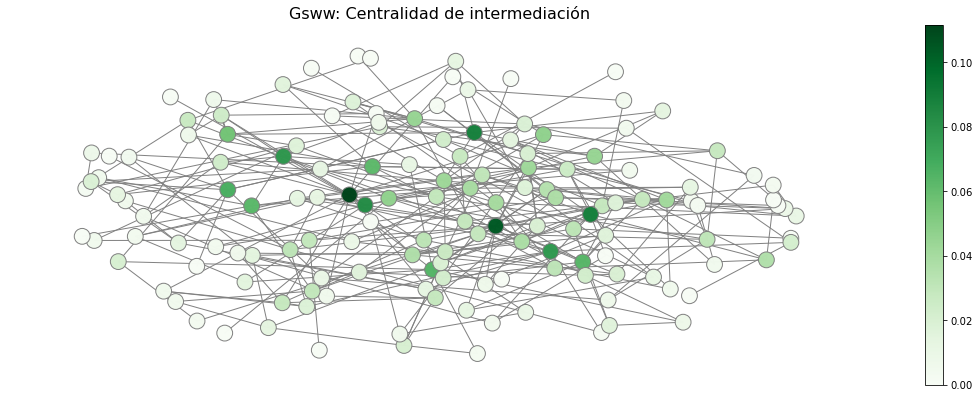

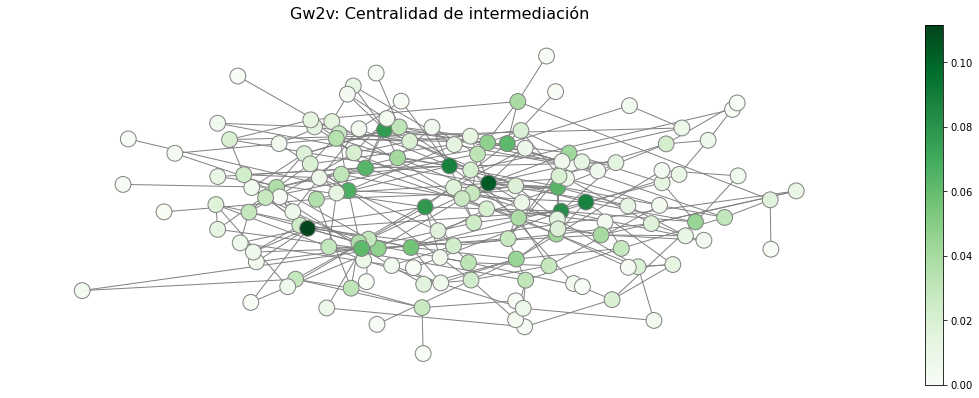

In [ ]:
plot_betweenness_centrality(sww_subgraph, 'Gsww', nodes_distance = 2)
plot_betweenness_centrality(w2v_subgraph, 'Gw2v', nodes_distance = 2)

Centralidado de Cercanía (Closeness):

Está basada en la distancia entre pares de nodos. Es el promedio de la eficiencia de cada nodo. No habla solamente de un nodo en particular, si no que habla de cómo es la distancia a cada uno de los nodos. **El nodo más importante es aquel que es más cercano al resto**.


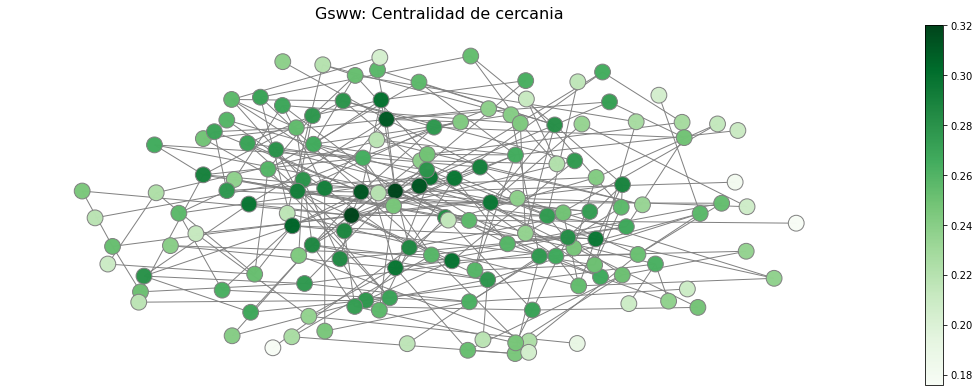

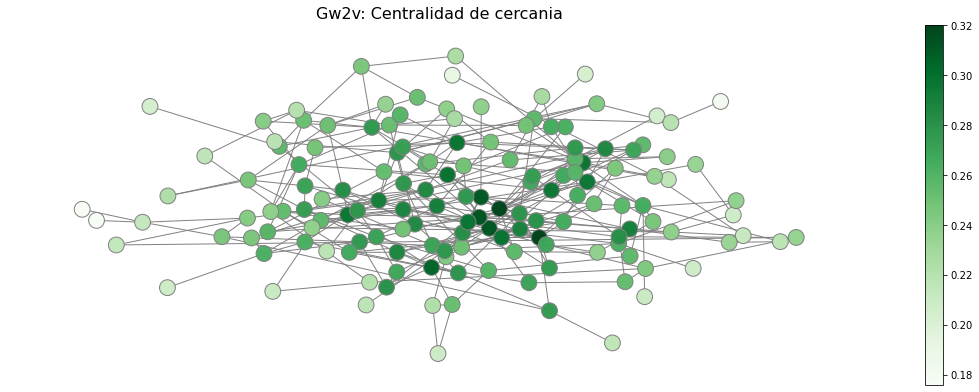

In [ ]:
plot_closeness_centrality(sww_subgraph, 'Gsww', nodes_distance = 2)
plot_closeness_centrality(w2v_subgraph, 'Gw2v', nodes_distance = 2)

Centralidado de autovalor:

No solo le importa el grado del nodo (cantidad de enlaces) si no también como son lo vecinos que lo rodean. Si el nodo que estoy analizando tiene grado alto y los nodos vecinos que están al lado también tienen grado alto, entonces ese nodo tendrá una centralidad alta. No mira toda la red, si no solo el entorno del nodo.


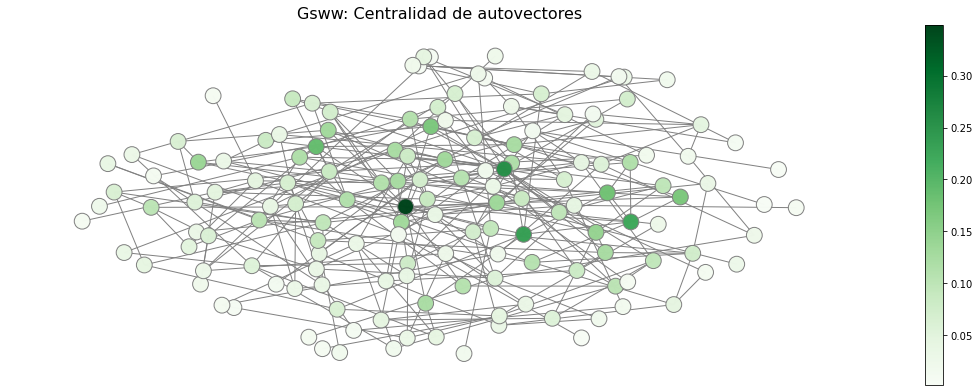

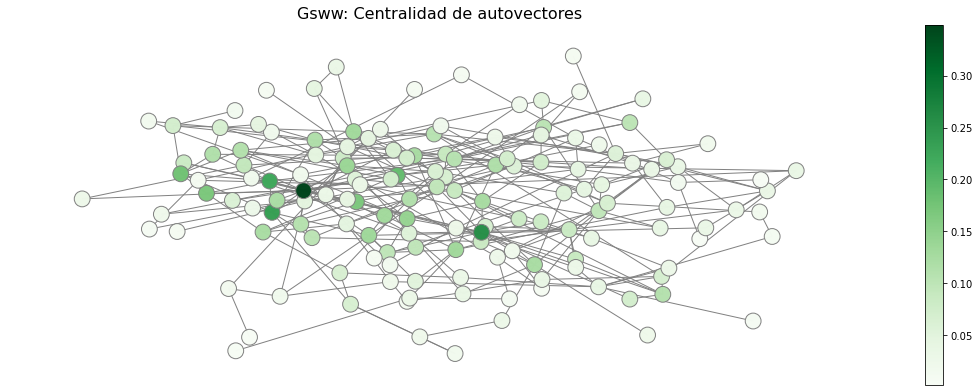

In [ ]:
plot_graph_eigenvector_centrality(sww_subgraph, 'Gsww', nodes_distance = 2)
plot_graph_eigenvector_centrality(w2v_subgraph, 'Gsww', nodes_distance = 2)

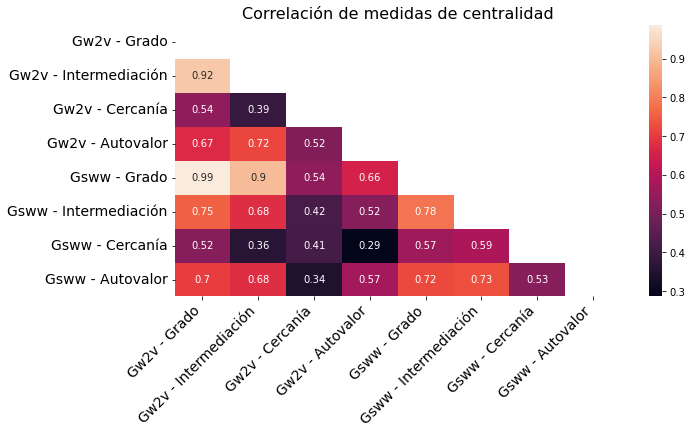

In [ ]:
plot_centrality_mesures_heatmap(w2v_graph, sww_graph, 'Gw2v', 'Gsww')

**Observaciones**



**Distribución de pesos**

Peso de la red:

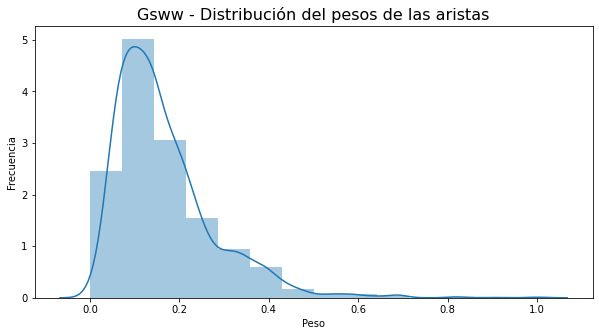

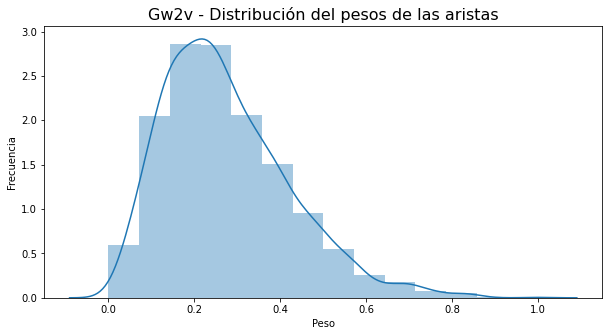

In [ ]:
plot_weight_dist(sww_graph, title='Gsww')
plot_weight_dist(w2v_graph, title='Gw2v')

**Observaciones**

Para ambos grafos las distribuciones de grado son muy similares pero no iguales, ya que hay palabras que existen en **Gsww** pero no existen en **Gw2v**. Por otro lado, se aprecia que tenemos muchos nodos de bajo grado. Esto ultimo se da en mayor medida en Gsww.

Pesos de las matrices de adyacencia:

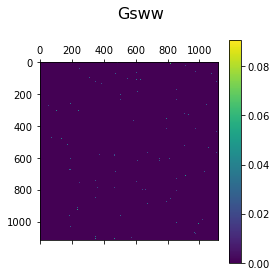

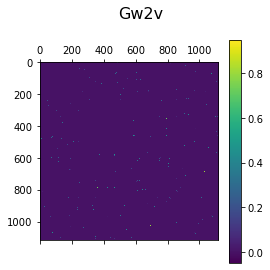

In [ ]:
plot_adjacency_matrix2(sww_graph, title='Gsww')
plot_adjacency_matrix2(w2v_graph, title='Gw2v')

**Observaciones**

* Ambas matices de adyacencia son muy esparsas o ralas. Esto nos dice que el grado de entrada salidad deeeeeeeee la mayoria de los nodos es muy bajo.
* Gw2v parece tener muchos nodos con pesos en general mas alto que Gsww. Si bien los pesos no tiene las mismas escalas en el punto **4.** (Carga Dataset) si comparamos dsitribucion de de los pesos de ambos grafos se aprecia que Gsww tiene pocos nodos con alta freciencia y Gw2v tiene valores mejor distribuidos.

**Distribución de grado**

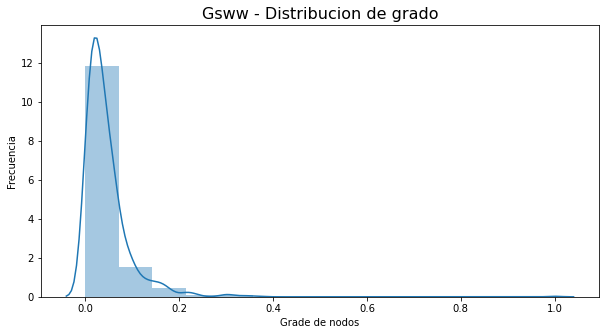

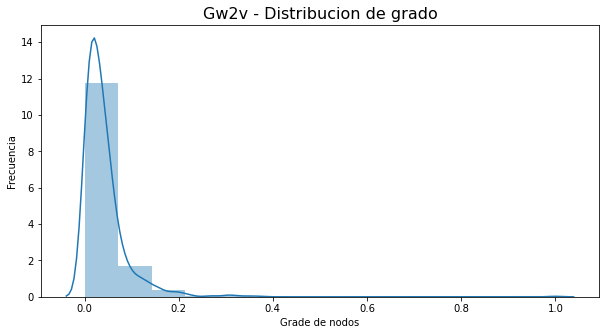

In [ ]:
plot_degree_dist(sww_graph, title='Gsww')
plot_degree_dist(w2v_graph, title='Gw2v')

**Obsercaciones**

Para ambos grafos las distribuciones de grado son muy similares pero no iguales, ya que hay palabras que existen en **Gsww** pero no existen en **Gw2v**. Por otro lado, se aprecia que tenemos muchos nodos bajo grado (la mayoria de grado 1) y muy pocos nodos de grado mayor a 1. Es decir que tenemos pocos nodos hubs. 

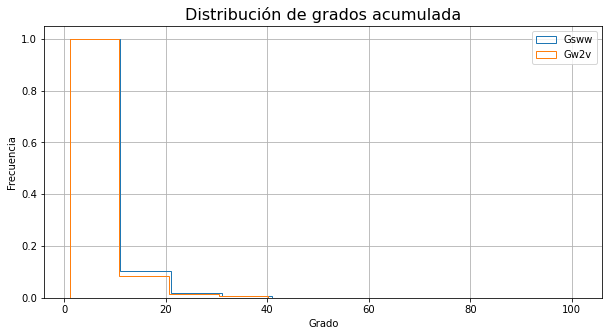

In [ ]:
plot_cumulative_degree_dists(sww_graph, w2v_graph, 'Gsww', 'Gw2v')

Si comparamos el grado de ambos grafos vemos que ambas distribuciones son muy similares. La diferencia radica en que la dsitribucion de **Gsww** disminuye su grado mas lentamente que **Gw2v**. Esto se debe a que **Gw2v** tiene menos conecciones ya que no todas la palabra del dataset SWW se encuentran en el embedding. 

**Coeficiente de Asortatividad**

* El coeficiente de asortatividad se trata del coeficiente de correlación de Pearson de los grados entre dos pares de nodos conectados.
* Valores positivos indican que existe una correlación entre nodos con grado similar, mientras que un valor negativo indica correlaciones entre nodos de diferente grado. 
* En general toma un valor comprendido entre -1 y 1. 
* Si es 1, se dice que la red es totalmente asortativa, cuando es 0 la red es no asortativa y cuando es -1 la red es disortativa.

Grafo W2V:

In [ ]:
nx.degree_assortativity_coefficient(w2v_graph)

-0.06383717717753612

Grafo SWW:

In [ ]:
nx.degree_assortativity_coefficient(sww_graph)

0.01848427888447672

**Obsercaciones:**

* **Gw2v** es una red **disociativa**, es decir que, existe un grado de correlacion entre nodos de distinto grado. Entonces, los nodos de menor grado se agrupan con los nodos de mayor grado.
* **Gsww** es una red **asociativa**, es decir que, existe un grado de correlacion entre nodos de igual grado. Entondes, los nodos se agrupa por igual grado.

**Camino mínimo**

Grafo W2V:

In [ ]:
graph_components_nodes_size(w2v_graph)

[1107, 3, 2, 2, 2, 2]

In [ ]:
largest_component_average_shortest_path_length(w2v_graph)

4.184928720896612

Grafo SWW:

In [ ]:
undirected_sww_graph = to_undirected_graph(sww_dataset, sww_graph)

In [ ]:
graph_components_nodes_size(undirected_sww_graph)

[1107, 3, 2, 2, 2, 2]

In [ ]:
largest_component_average_shortest_path_length(undirected_sww_graph)

4.184928720896612

**Obsercaciones**

Dado que ambos grafos tiene la misma topologia es de esperar que tenga el mismo número de arista en su camino minimo.

**Diámetro**

El diametro de un grafo es el camino mas largo entre dos pares de nodos y es calculado en base a los pesos de las aristas.

Grafo W2V:

In [ ]:
largest_component_diameter(w2v_graph)

10

Grafo SWW:

In [ ]:
largest_component_diameter(undirected_sww_graph)

10

**Obsercaciones**

Dado que ambos grafos tiene la misma topologia es de esperar que tenga el mismo diametro.

**Densidad**

La densidad de un grafo es el cociente entre el número de aristas y el número de todos las posibles aristas.

Grafo W2V:

In [ ]:
nx.density(w2v_graph)

0.0045339308107103906

Grafo SWW:

In [ ]:
nx.density(sww_graph)

0.0024999879885266407

**Observaciones**

Se aprecia que Gsww tiene practicamente la mitad de densidad que Gw2v.  

#### 5.3. Comunidades

Detectar comunidades en Gsww y Gw2v con el algoritmo que consideren más indicado, justificar por qué. Calcular el indice de modularidad en cada caso ¿Qué pueden decir de las comunidades?
Comparar las comunidades de ambas redes con el índice rand (u otra métrica que considere adecuada) ¿Son similares?
Visualizar uno de los grafos, y pintarlo según las comunidades del otro ¿Qué se puede decir?
También se puede analizar la resolución del algoritmo de por el cuál se detectan las comunidades. Para ello, pueden explorar estructuras dentro de alguna de las comunidades.

Se usa el algortimo de Girvan_Newman que funciona con grafos dirigidos y no dirigidos. 
Se submuestra la cantidad de nodos a 300 ya que el algoritmo no escala bien, se seleccionan aquellos que tengan la mayor centralidad de grado.

In [53]:
w2v_subgraph=top_degree_centrality_subgraph(w2v_graph, top = 300)  # si pongo 150 tambien funciona , 60 para dibujar bien, con 300 tambien anduvo
w2v_subgraph = subgraph_without_isolated_nodes(w2v_subgraph)
sww_subgraph = sww_graph.subgraph(list(w2v_subgraph.nodes))

Funciones

In [19]:
def assign_community_girvan_newman(G):
  modulos = nx.community.girvan_newman(G)
  modularidad=[]
  mod_max = -999

  for communities in modulos:
      #print(tuple(sorted(c) for c in communities))
      n_modularidad = nx.community.modularity(G,tuple(sorted(c) for c in communities))
      #print(n_modularidad)
      modularidad.append(n_modularidad)
      if n_modularidad>mod_max:
        mod_max=n_modularidad
        com_max = tuple(sorted(c) for c in communities)
  print(modularidad)
  plt.plot(modularidad);
  plt.xlabel('Diferentes particiones')
  plt.ylabel('Coeficiente de Modularidad')
  k=np.argmax(modularidad)
  print(mod_max)
  print(com_max)
  return k, mod_max, com_max, communities

In [20]:
def partition_set_to_dict(m):
    d = {}
    for i,c in enumerate(m):
        for n in c:
            d[n] = i
    return d

In [21]:
from sklearn.metrics.cluster import adjusted_rand_score

[0.01582820279426006, 0.03402856025269088, 0.07119264188619936, 0.11943916781597397, 0.3194644449942187, 0.4009257589819119, 0.4064347145094804, 0.433718632081909, 0.44404114099915865, 0.45140345459552406, 0.45768641627338746, 0.48278136078321504, 0.4892114913013395, 0.49359312711945985, 0.4928698960010051, 0.49680406845900227, 0.49611285554754425, 0.4965638490708361, 0.49756535447195976, 0.49336631039103523, 0.49309566670681915, 0.48945867085417294, 0.4889715876660595, 0.4886973319024505, 0.48866503806286515, 0.4863708902177338, 0.48398284107119316, 0.4827055104225127, 0.4807855096957933, 0.47949632077905, 0.47849344684454503, 0.47445800042937086, 0.4731860950675975, 0.47133930045977246, 0.47044351868580325, 0.468054360451223, 0.46547789003481616, 0.46185244845383333, 0.4611405000766359, 0.4603419888525065, 0.45914808879124636, 0.4559337357630038, 0.45210583405969224, 0.4499686083469687, 0.4470520359437892, 0.4466707314954815, 0.4433293761110671, 0.4400314534205039, 0.4391889218697225

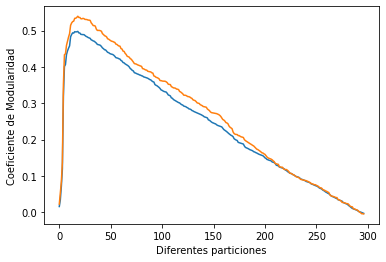

In [54]:
k_sww, mod_max_sww, com_max_sww, comms=assign_community_girvan_newman(sww_subgraph)
k_w2v, mod_max_w2v, com_max_w2v, comms=assign_community_girvan_newman(w2v_subgraph)

In [55]:
print(k_sww)
print(k_w2v)

18
18


El índice rand entre Gsww y Gw2v se presenta a continuación

In [56]:
values = [v for n,v in partition_set_to_dict(com_max_sww).items()]
values_sww=values
values = [v for n,v in partition_set_to_dict(com_max_w2v).items()]
values_w2v=values
adjusted_rand_score(values_sww, values_w2v)

1.0

Para graficar los nodos recalculo todo para los 60 nodos mas importantes

In [52]:
w2v_subgraph=top_degree_centrality_subgraph(w2v_graph, top = 60)  # si pongo 150 tambien funciona , 60 para dibujar bien, con 300 tambien anduvo
w2v_subgraph = subgraph_without_isolated_nodes(w2v_subgraph)
sww_subgraph = sww_graph.subgraph(list(w2v_subgraph.nodes))

[0.43335351347409035, 0.5875153475107295, 0.6076156163381163, 0.6319350702428614, 0.6296098353685549, 0.6289027955378451, 0.6154119032814515, 0.6147319882747859, 0.6079171195790688, 0.58726595740426, 0.5790817827076451, 0.5502610625080806, 0.5261983513285106, 0.521300820244729, 0.5130602513331494, 0.5067891103675368, 0.4963467486021665, 0.4865256899900895, 0.47738550491719056, 0.45603604222833793, 0.4457477273252174, 0.43624175531995263, 0.42649710150663045, 0.3937832082905339, 0.38394192409679073, 0.3760643297126807, 0.36436600816912235, 0.35491356620858494, 0.34553745699798877, 0.3187440811707377, 0.30473946543281494, 0.2907744850154606, 0.2738507016897865, 0.2470887999951092, 0.23665815356637165, 0.22919708945710682, 0.21953833217285462, 0.21019397501883125, 0.18838911482611126, 0.17826547762062211, 0.1639083639419772, 0.1393926669059262, 0.1216497207306947, 0.1122596712967431, 0.09147558028434959, 0.058383414373976865, 0.04673814456331953, 0.03806060747286434, 0.02969098485539624, 

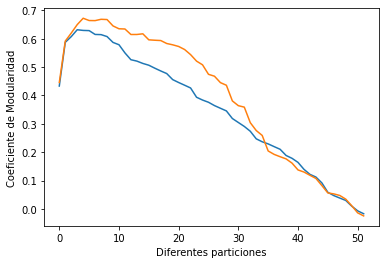

In [26]:
k_sww, mod_max_sww, com_max_sww, comms=assign_community_girvan_newman(sww_subgraph)
k_w2v, mod_max_w2v, com_max_w2v, comms=assign_community_girvan_newman(w2v_subgraph)

Fijo layout

In [28]:
k_l=.2
k_l=.2
pos_sww = nx.spring_layout(sww_subgraph,k=k_l)
pos_w2v = nx.spring_layout(w2v_subgraph,k=k_l)

Grafico Gsww con colores según Gsww

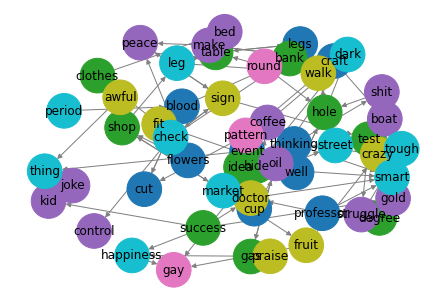

In [34]:
plt.figure()
values = [v for n,v in partition_set_to_dict(com_max_sww).items()]
nx.draw(sww_subgraph,pos=pos_sww, with_labels=True,cmap=plt.cm.tab10,node_color = values, font_color='black', edge_color='gray', node_size=1200)
values_sww=values

Grafico Gsww con colores según Gw2v

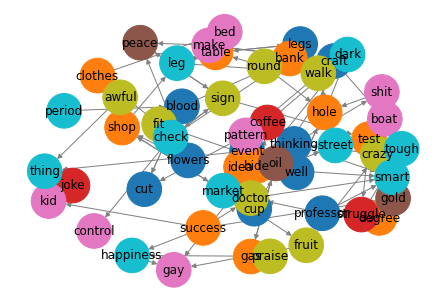

In [35]:
plt.figure()
values = [v for n,v in partition_set_to_dict(com_max_w2v).items()]
nx.draw(sww_subgraph,pos=pos_sww, with_labels=True,cmap=plt.cm.tab10,node_color = values, font_color='black', edge_color='gray', node_size=1200)
values_w2v=values

* **Opcional 2**: Utilizar distintos algoritmos y comparar los resultados.

Uso el algoritmo de Louvain, que solo puede aplicarse a grafos no dirigidos, por lo cual lo primero que hago es pasar Gsww a no dirigido.

Gsww

In [36]:
undirected_sww_graph = to_undirected_graph(sww_dataset, sww_subgraph)
k_l=.2
pos_u_sww = nx.spring_layout(undirected_sww_graph,k=k_l)
pos_w2v = nx.spring_layout(w2v_subgraph,k=k_l)
#pos_u_sww = nx.spring_layout(undirected_sww_graph,k_l)

In [37]:
#!pip install python-louvain
import community.community_louvain as community_louvain

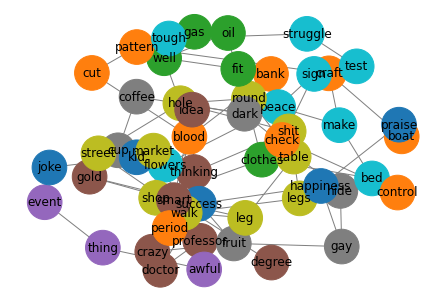

In [43]:
partition = community_louvain.best_partition(undirected_sww_graph)
partition_sww=partition
values_obs = [v for n,v in partition.items()]
nx.draw(undirected_sww_graph,pos=pos_u_sww, with_labels=True,cmap=plt.cm.tab10,node_color = values_obs, font_color='black', edge_color='gray',node_size=1200)

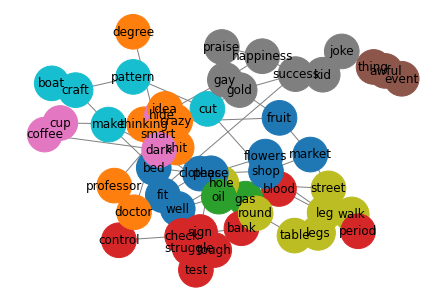

In [44]:
partition = community_louvain.best_partition(w2v_subgraph)
partition_w2v=partition
values_obs = [v for n,v in partition.items()]
nx.draw(w2v_subgraph,pos=pos_w2v, with_labels=True,cmap=plt.cm.tab10,node_color = values_obs, font_color='black', edge_color='gray',node_size=1200)

* **Opcional 3**: ¿Cómo cambian los resultados si se considere Gsww como no-dirigido o no-pesado? ¿Y para Gw2v?

Vuelvo a aplicar Girvan_Newman pero al grafo no dirigido

[0.4219040488097783, 0.5769630380767076, 0.5931729354119126, 0.6287753955439299, 0.6357422607687417, 0.6321873098729012, 0.6285764776300211, 0.6299916464362908, 0.6222341002645917, 0.6012870949811282, 0.59078693404471, 0.5597364088990214, 0.539173864301115, 0.5315018795310704, 0.5223015157581903, 0.5125846459203655, 0.5001573782479329, 0.4874494277252124, 0.4767612399042505, 0.4653226202962856, 0.45165030041395465, 0.44002436973963716, 0.42822890569490046, 0.3998182952770674, 0.3892210734432966, 0.37719558015863397, 0.3631269926252273, 0.3418927299907347, 0.3302825343668911, 0.3099532039512005, 0.29296270178958156, 0.2759667097947398, 0.2537198183853539, 0.2368771458802864, 0.22362786011447439, 0.2090239320447968, 0.19704385664361215, 0.18522812059433832, 0.17610423088549956, 0.16373344231093898, 0.1455343734372456, 0.13308361089498452, 0.1210545791372959, 0.10098162186574844, 0.08966037532959535, 0.06445777590407574, 0.04779053509537386, 0.03355670227229835, 0.02304415722824811, 0.010

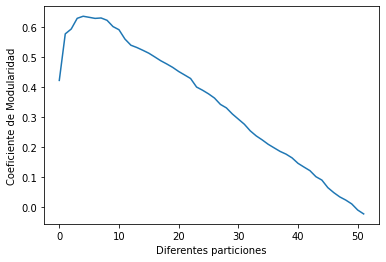

In [45]:
k_sww_nd, mod_max_sww_nd, com_max_sww_nd, comms=assign_community_girvan_newman(undirected_sww_graph)

In [46]:
values = [v for n,v in partition_set_to_dict(com_max_sww_nd).items()]
values_sww_nd=values
adjusted_rand_score(values_sww, values_sww_nd)

0.8256487005984648

El indice rand ajustado obtenido cambia.

* **Opcional 4**: Utilizar algoritmos de reducción de dimensionalidad como MDS, tSNE, o UMAP para ubicar las palabras en dos dimensiones y pintar según las comunidades identificadas. Se puede elegir un subconjunto de palabras para que sea más claro. También pueden proyectar en el espacio construido con word2vec y pintar según las comunidades identificadas en Gsww, o viceversa.

In [ ]:
# graph_modularity(sww_graph)
# graph_modularity(w2v_graph)

#### 5.4. Small-world y redes prototípicas

Existen trabajos previos que muestran que tanto la red de asociaciones (Gsww) como la red semántica (Gw2v) tienen estructura de small-world [5, 6]. Comparar las características de redes, como el camino mínimo, con distintos modelos de redes, en particular con redes small-world. Para ello generar N redes small-world con el mismo número de nodos y aristas, y evaluar si las características medidas en Gsww y Gw2v podrían pertenecer a dichas distribuciones.

* **Opcional 4**: Además de realizar esta tarea con el small-world, repetirlo con las random o scale-free.

COMPLETAR